# Summary

This notebook is organized into the following sections:

- [Solving Dependencies](#Solving-Dependencies)
- [Importing Data](#Importing-Data)
- [Defining Training and Testing Functions](#defining-training-and-testing-functions)
- [BERT Model](#bert-model)
- [XLNet Model](#xlnet-model)


# Solving Dependencies

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from transformers import BertTokenizer, BertForSequenceClassification, \
    XLNetTokenizer, XLNetForSequenceClassification

# Set seed
SEED = 461249612

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Importing Data

In [18]:
def readCreateDataframe(folder_path: Path, fake: bool = False) -> pd.DataFrame:
    """
    Read the text files in the folder and create a dataframe with the text and label.
    The label is 1 if the text is fake

    Args:
        folder_path: Path to the folder containing the text files
        fake: Boolean indicating if the text is fake

    Returns:
        pd.DataFrame: Dataframe containing the text and label

    """
    if not folder_path.is_dir():
        raise ValueError("Folder path does not exist")
    data = []
    for file in sorted(folder_path.iterdir()):
        text = file.read_text()
        if fake:
            data.append([text, 1])
        else:
            data.append([text, 0])
    return pd.DataFrame(data, columns=["text", "label"])

In [19]:
df_fake = readCreateDataframe(Path("Fake.br-Corpus/full_texts/fake"), fake=True)
df_true = readCreateDataframe(Path("Fake.br-Corpus/full_texts/true"), fake=False)

In [20]:
df = pd.concat([df_fake, df_true], ignore_index=True)
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True) # to shuffle 

In [21]:
df

text  label
0      © DPA Se chamar “Fátima” num país avesso ao q...      0
1     Esposa de Lula sofre AVC e está em estado grav...      1
2     Thiago Lacerda solta o verbo: "Artistas defend...      1
3     Barbosa : "Michel Temer não tem legitimidade p...      1
4     Barroso: "Criamos uma sociedade cheia de ricos...      1
...                                                 ...    ...
7195  Festejos ao Dois de Julho reúnem famílias e tê...      0
7196  Candidato Luiz Castro participa de entrevista ...      0
7197  BNDES e FRIBOI: Uma das famílias mais poderosa...      1
7198  Vaquinha virtual da Dona Dilma já conseguiu ar...      1
7199  Psiquiatra emite diagnóstico de Lula: "Persona...      1

[7200 rows x 2 columns]

In [22]:
del df_fake, df_true

# Defining Training and Testing Functions

In [23]:
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs, device):
    """
    Train and validate a model.

    Args:
        model: The PyTorch model to be trained.
        train_dataloader: DataLoader for the training set.
        val_dataloader: DataLoader for the validation set.
        optimizer: Optimizer for training the model.
        num_epochs: Number of epochs for training.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        avg_loss_list: List of average training losses for each epoch.
        val_loss_list: List of average validation losses for each epoch.
    """
    model = model.to(device)
    avg_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1} [Training]')
        
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(input_ids, labels=labels)
            loss = outputs.loss
            
            # Backward pass
            loss.backward()
            
            # Update weights
            optimizer.step()
            
            # Update progress bar
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{total_loss/(progress_bar.n+1):.4f}'})
        
        # Calculate average training loss
        avg_loss = total_loss / len(train_dataloader)
        avg_loss_list.append(avg_loss)
        print(f'\nEpoch {epoch + 1} - Average Training Loss: {avg_loss:.4f}')
        
        # Validation phase
        model.eval()
        val_total_loss = 0
        with torch.no_grad():
            val_progress_bar = tqdm(val_dataloader, desc=f'Epoch {epoch + 1} [Validation]')
            
            for batch in val_progress_bar:
                # Move batch to device
                input_ids = batch[0].to(device)
                labels = batch[1].to(device)
                
                # Forward pass
                outputs = model(input_ids, labels=labels)
                loss = outputs.loss
                
                # Update validation loss
                val_total_loss += loss.item()
                val_progress_bar.set_postfix({'val_loss': f'{val_total_loss/(val_progress_bar.n+1):.4f}'})
        
        # Calculate average validation loss
        avg_val_loss = val_total_loss / len(val_dataloader)
        val_loss_list.append(avg_val_loss)
        print(f'Epoch {epoch + 1} - Average Validation Loss: {avg_val_loss:.4f}')
    
    return avg_loss_list, val_loss_list


In [ ]:
def evaluate_model(model, test_dataloader, device):
    """
    Evaluate the model on a test dataset.

    Args:
        model: The PyTorch model to be evaluated.
        test_dataloader: DataLoader for the test set.
        device: Device to run the model on ('cuda' or 'cpu').

    Returns:
        y_true: List of true labels.
        y_pred: List of predicted labels.
    """
    model = model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch[0].to(device)
            labels = batch[1].to(device)
            
            # Forward pass
            outputs = model(input_ids, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            # Collect true and predicted labels
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    
    return y_true, y_pred

# BERT Model

## Tokenizing

We will use the BERTTokenizer from HuggingFace

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
input_ids = [
    tokenizer.encode(
        text, 
        add_special_tokens=True, 
        return_tensors='pt',  
        truncation=True, 
        padding='max_length', 
        max_length=512) 
    for text in df.text]

In [25]:
input_ids

[tensor([[  101,  1075,  1040,  4502,  7367, 15775,  7849,  1523, 27596,  1524,
          16371,  2213,  6643,  2483, 13642, 24137, 20118, 10861,  1041,  1523,
           9765,  5521,  6806,  1524,  7110,  2850, 14736,  2015,  7367,  9686,
           3366,  1523,  9765,  5521,  6806,  1524, 14841,  6299,  1037,  2310,
           2099,  4012,  8529,  2050,  2128,  3669, 10440,  2080,  4830, 24209,
           2389,  1010, 18499,  8529, 14804,  2080,  1010,  7367,  7842,  4783,
          14163,  9956, 13433, 14194,  2080,  1010,  2139,  2041,  3217,  1041,
           3419,  8447, 18609,  1523, 10927,  2140,  1524,  1041,  1523,  4190,
          25090, 22911,  7113,  1524, 18499, 13675, 27605, 15460,  2891,  2061,
          17080, 12269,  1010, 17522,  4502, 10230, 10861,  9686, 25778, 29122,
           1051, 21045,  2080, 18609, 11503, 29344,  1041,  8529,  2566,  7389,
           9077,  1006, 11498,  4487,  6290, 20118,  7163,  5302,  1007,  1010,
          16137, 23233,  2050,  4012, 28

## Creating the Dataloader

In [26]:
# Original train-test split
y = df.label.tolist()
X_train, X_test, y_train, y_test = train_test_split(input_ids, y, test_size=0.2, random_state=SEED)

# Additional train-validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# Create TensorDatasets
train_dataset = TensorDataset(torch.stack(X_train).squeeze(1), torch.tensor(y_train))
val_dataset = TensorDataset(torch.stack(X_val).squeeze(1), torch.tensor(y_val))
test_dataset = TensorDataset(torch.stack(X_test).squeeze(1), torch.tensor(y_test))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Training

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
avg_loss_list, val_loss_list = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=1e-5),
    num_epochs=5,
    device=device)


Epoch 1 [Training]:   0%|          | 1/576 [01:09<11:06:29, 69.55s/it, loss=0.6433]


KeyboardInterrupt: 

Text(0, 0.5, 'Average Loss')

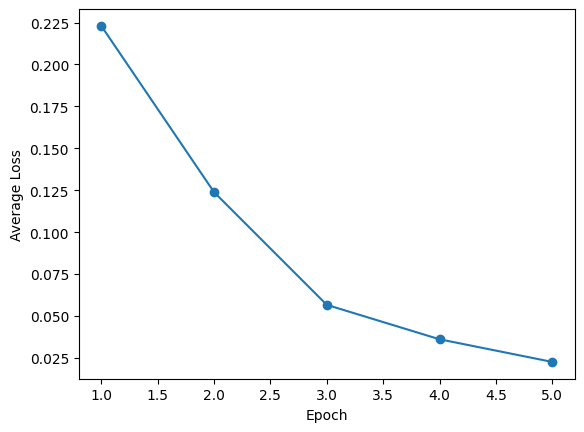

In [ ]:
epochs = np.arange(1, len(avg_loss_list) + 1, 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, avg_loss_list, marker='o', label='Training Loss')
plt.plot(epochs, val_loss_list, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Testing the Results

In [ ]:
y_true, y_pred = evaluate_model(model, test_dataloader, device)

In [21]:
report = classification_report(y_true, y_pred, target_names=["Fake", "Real"])
print(report)   

              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97       716
        Real       0.96      0.99      0.97       724

    accuracy                           0.97      1440
   macro avg       0.98      0.97      0.97      1440
weighted avg       0.98      0.97      0.97      1440



## Saving Model

In [14]:
model.save_pretrained("BERT_retrained")

# XLNet Model

## Tokenizing

We will use the pretrained XLNetTokenizer from HuggingFace

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
inputs_ids = [
    tokenizer.encode(
        text, 
        add_special_tokens=True, 
        return_tensors="pt", 
        truncation=True, 
        padding='max_length', 
        max_length=512) 
    for text in df.text]

[tensor([[   17,     0,   347,  5896,  2100,    17,  2409,  1880,   221,  7697,
             46,  6109,   407,    17,  8713,    17, 17850,    23,    17, 17272,
           2096,    24,   155,    17,  1895,    17,    93,   221,  1277,  2156,
           2654,   407,    24, 12236,    17, 18714,    23,    17,  1022,    17,
          16838,   221,  1277,  2156,  2654,   407,    17,  7578,   213,    24,
             17,  2013,  2748,    17,  9681,    17,    88,  6657,   780,   155,
           8075,    17, 13853,    19, 11760,    17,  1212,  2483,  1079,    19,
             17,  1022,    17,  1512,  1156,    17,  5023, 10107,    17, 22674,
            721,    19,   321,    78,   986,    17,    93,    22,    98,  4304,
           2748,   155,   221,   101,  3657,   407,    17,    93,   221,  7433,
           6225, 12485,  6536,   407, 11760,    17,  6752,  1841, 17883,    23,
            102,  1937, 10012,    23,    19, 16960,  9059,   712,    17,  1895,
             17,   202, 10564,  9817,   

In [ ]:
inputs_ids

## Creating the Dataloader

In [ ]:
# Original train-test split
y = df.label.tolist()
X_train, X_test, y_train, y_test = train_test_split(input_ids, y, test_size=0.2, random_state=SEED)

# Additional train-validation split from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# Create TensorDatasets
train_dataset = TensorDataset(torch.stack(X_train).squeeze(1), torch.tensor(y_train))
val_dataset = TensorDataset(torch.stack(X_val).squeeze(1), torch.tensor(y_val))
test_dataset = TensorDataset(torch.stack(X_test).squeeze(1), torch.tensor(y_test))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Training

In [ ]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2)

In [ ]:
avg_loss_list, val_loss_list = train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=1e-5),
    num_epochs=5,
    device=device)


Epoch 1 [Training]:   0%|          | 1/576 [01:09<11:06:29, 69.55s/it, loss=0.6433]


KeyboardInterrupt: 

Text(0, 0.5, 'Average Loss')

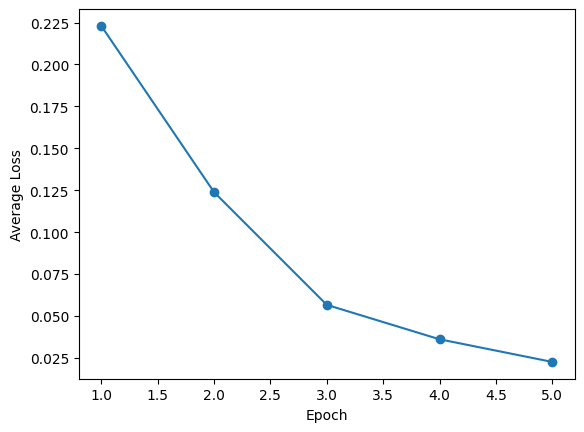

In [ ]:
epochs = np.arange(1, len(avg_loss_list) + 1, 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, avg_loss_list, marker='o', label='Training Loss')
plt.plot(epochs, val_loss_list, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Testing the Results

In [ ]:
y_true, y_pred = evaluate_model(model, test_dataloader, device)

In [ ]:
report = classification_report(y_true, y_pred, target_names=["Fake", "Real"])
print(report)   

              precision    recall  f1-score   support

        Fake       0.99      0.95      0.97       716
        Real       0.96      0.99      0.97       724

    accuracy                           0.97      1440
   macro avg       0.98      0.97      0.97      1440
weighted avg       0.98      0.97      0.97      1440



## Saving Model

In [ ]:
model.save_pretrained("XLNet_retrained")